This notebook is written by [Yu Chen](https://yuchenakaleslie.github.io/) only for the practical assignment of SME. 

Yu Chen
--
PhD candidate          | *Institute for Risk and Uncertainty, University of Liverpool*<br>
Early-Stage-Researcher | *EU-ITN-H2020 MSCA project URBASIS*


Personal website: https://yuchenakaleslie.github.io/<br>
ResearchGate: https://www.researchgate.net/profile/Yu-Chen-402<br>
Contact: yu.chen2@liverpool.ac.uk


All rights reserved.

===================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import datetime
import gpflow as gf
from rich import print
from collections import namedtuple
from sklearn.metrics import mean_absolute_error
import tensorflow_probability as tfp
tfd = tfp.distributions

2023-11-16 16:21:02.000221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 16:21:02.219667: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 16:21:04.714178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/share/soft/anaconda/anaconda3/envs/tf/lib/libfabric::/usr/local/cuda/lib64
2023-11-16 16:21:04.714389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvin

In [2]:
# set up a global plt style for the script
# plt.style.use('classic')
plt.rcParams.update({
        "font.size": 11,
        "text.usetex": True,
        "font.family": "serif",
        "legend.fontsize": 'small',
        })

## Table of Contents
#### [1. Introduction](#introduction)
#### [2. The library code modules](#library)
#### [3. Data exploration (pre-processing and cleaning)](#data_exploration)
#### [4. Data visualization](#data_visualization)
#### [5. Predictive modelling](#predictive_modelling)
#### [6. Final thoughts and discussion](#final_throughts)

***
<a id="introduction"></a>
# 1. Introduction

> As an answer to the practical assignment, two files, as listed below, are submitted:

1. A `Jupyter notebook` file (this file) as a standalone solution containing both code and explanation. It can be better viewed via `nbviewer` at [this address](https://nbviewer.org/github/leslieDLcy/SME/blob/main/notebooks/SME_assignment_byYuChen.ipynb#). The original `.ipynb` file is stored in this repository.

2. A accompaning `PDF report` (at this address) clearly summarizing the procedures and futher thoughts on Machine Learning strategies that can deliver more possibilities for this assignment. <font color='blue'>This report is for a clean read without "disturbing" by codes.</font>

***
<a id="library"></a>
# 2. The library code modules

> Throughout this analysis, I meant to write `library codes` that can serve as **recipes**, for instance, to solve a certain data problem, create a model, generate a figure, etc. Most importantly, these library codes can be re-used by others (*e.g.* team members or clients) later on, as in being adopted in `user code`. 

> Notably, these library codes can be easily packaged into a Python package, facilitating the sharing and usage by others

In [3]:
def inspect_date_format(df):
    """ identifying rows with wrong date formatting """
    
    m = pd.to_datetime(df['Date'], format="%d/%m/%Y", errors='coerce').isna()
    wrong_dates = df.loc[m, 'Date'].unique().tolist()
    print(f"Detected wrong date format: {wrong_dates}")
    
    # pinpoint the rows with such incorrect dates
    for i in wrong_dates:
        print(f"row index with wrong dates '{i}' ==> {df[df['Date'] == i].index}")

In [4]:
def date_formatting(df):
    """ recipe for datetime indexing of dataframe """
    
    return (df
            .assign(datetime = pd.to_datetime(df['Date'], format="%d/%m/%Y"))  
            .set_index('datetime')
            .drop(['Day', 'Date'], axis=1)
           )

In [5]:
def inspect_missing_data(df, option):
    """ look for months with missing records from the history 
    
    args:
        df: the query dataframe
        
    return:
        information (stdout) as to missing months
    """
    
    if option == 'missing_month':
        s = df.resample('MS').size()
        mm = s[s == 0].index.to_period('M')
        num = len(mm)
        print(f"Total number of months with missing records: {num}")
        print("Missing months are: \n", mm)
        
    elif option == 'nan':
        print(data.isna().sum())
    else:
        print('Wrong option')

In [6]:
def inspect_duplicates(df):
    """ check if exising duplicated data """
    
    num = data.duplicated().sum()
    print(f"Total number of duplicates: {num}")
    print(f"If existing, display duplicated rows:\n\n {data[data.duplicated()]}")

In [7]:
def boxplot_annual_averge(df):
    """ Reproduce Figure 1
    
    note:
        Figure 1: Average debts over years
    """
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.boxplot(
        data=df, 
        y='totalU', 
        x='Year', 
    )
    ax.set_ylabel('Total Debts')
    ax.yaxis.set_major_formatter('£{x:,.2f}')
    ax.grid(which='both', ls=':')

In [8]:
def plot_monthly_debt_history(df):
    """ Reproducing Figure 2 
    
    note:
        Figure 2: the total debts from all lenders over months and years
    """

    fig, axs = plt.subplots(
        nrows=3, ncols=4, 
        sharex=True, sharey=True,
        layout="constrained",
        figsize=(10, 9))

    monthly_data_gen = (df[df['Year'] == year] for year in range(2013, 2024))
    year_gen = iter(range(2013, 2024))

    for row in range(4):
        for col in range(4):
            try: 
                year_average_plot(ax=axs[row, col], df=next(monthly_data_gen), title=next(year_gen))
            except Exception:
                pass

    fig.delaxes(axs[2][3])

In [9]:
def plot_total_debt_history(df):
    """ Reproduce Figure 3 
    
    note:
        Figure 3: Total monthly debts from all lenders starting from October 2013
    """
    
    fig, ax  = plt.subplots(figsize=(8, 6))
    ax.plot(df.index, df['totalU'], color='black', 
            ls = '-', marker='.', 
            mfc='salmon', mec='salmon',
           label='historical observation')
    ax.yaxis.set_major_formatter('£{x:,.2f}')
    ax.set_ylabel('Total Debts')
    ax.set_xlabel('Months starting at Oct 2013')
    ax.legend(loc='upper left')
    ax.grid(which='both', ls=':')

In [10]:
def year_average_plot(ax, df, title):
    """ A template for creating Figure 2.
    
    Control the plotting style of a single axe in creating Figure2.
    It corresponds the monthly total debts in each year.
    
    args:
        ax: Matplotlib axe
        df: the data frame
        title: which year
    """
    # plotting style
    ax.plot(df.Month, df.totalU, 
            color='black', marker='o', 
            ls='-', lw=2, mfc = 'salmon', 
            mec = None, markersize=8)

    # x-axis formatting
    ax.set_xlim(0, 13)
    ax.xaxis.set_major_locator(
        mpl.ticker.FixedLocator(np.arange(1,13)))
    
    # y-axis formatting
    ax.set_ylim(200000, 800000)
    ax.yaxis.set_major_locator(
        mpl.ticker.FixedLocator(
            [300000, 400000, 500000, 600000, 700000]))
    ax.yaxis.set_major_formatter('£{x:,.2f}')
    ax.yaxis.set_minor_locator(
        mpl.ticker.AutoMinorLocator(n=2))

    ax.grid(which='both', ls=':')
    ax.set_title(f'{title}')

In [11]:
def plot_which_lender_history(df, lender_name):
    ax = df[lender_name].plot(xlabel='Year', ylabel='Debt', legend=True)
    ax.yaxis.set_major_formatter('£{x:,.2f}')
    ax.grid(which='both', ls=':')

In [12]:
TargetTransform = namedtuple('TargetTransform', ['mean_value', 'scale', 'split_index'])

In [13]:
def prepare_TrainTest_data(df, split=0.8):

    """ prepare the training and test data given a split
    
    args:
        split: split ratio
    """
    y = df[['totalU']].to_numpy().reshape(-1, 1)
    y = y - y.mean()
    X = (df.index.year + df.index.month / 12).to_numpy().reshape(-1, 1)
    
    # change unit to million
    y = y / 1000_000
    
    split_index = int(split * len(df))
    x_train, y_train = X[:split_index], y[:split_index]
    x_test, y_test = X[split_index:], y[split_index:]
    tt = TargetTransform(mean_value=y.mean(), scale=1000_000, split_index=split_index)

    return x_train, y_train, x_test, y_test, tt

In [14]:
def gp_modelling(X, y):
    
    # get the zero-mean process
    model = gf.models.GPR(
        (X, y),
        kernel=gf.kernels.SquaredExponential()
        + gf.kernels.Periodic(gf.kernels.SquaredExponential(), period=1.0),
        # likelihood=gpflow.likelihoods.Gaussian(scale=gpflow.functions.Polynomial(degree=2)),
        # noise_variance = 10_000,
    )

    opt = gf.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    
    return model

In [15]:
def gp_plotting(X_plot, y_mean, y_var, tt):
    
    # noisy prediction
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)
    y_lower_3sigma = y_mean - 3 * np.sqrt(y_var)
    y_upper_3sigma = y_mean + 3 * np.sqrt(y_var)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    # ground truth 
    ax.plot(x_train, y_train, 
            color="green", label="observation", ls='',
             marker='x', ms=5, mew=1.5,
             mec = 'coral', mfc = 'coral')
    
    # ground truth
    ax.plot(x_test, y_test, 
            color="green", ls='',
             marker='x', ms=5, mew=1.5,
             mec = 'coral', mfc = 'coral')
    
    # mean function
    ax.plot(X_plot, y_mean, "-", color="C0", label="mean prediction", zorder=10)

    # 95% confidence interval
    ax.fill_between(
        X_plot[:, 0], y_lower[:, 0], y_upper[:, 0], color="lightblue", alpha=0.3, label='predictive interval')

    # 99% confidence interval
    ax.fill_between(
        X_plot[:, 0], y_lower_3sigma[:, 0], y_upper_3sigma[:, 0], color="lightblue", alpha=0.2)

    ax.axvline(x=x_test[0], ymin=0, ymax=1, c='green', lw=0.75, ls='--', label='train/test split')
    ax.axvline(x=x_test[-1], ymin=0, ymax=1, c='purple', lw=0.75, ls='--', label='future forecast')
    ax.axvline(x=X_plot[-1], ymin=0, ymax=1, c='r', lw=0.75, ls='--', label='current date: 2023/11')
    
    ax.set_ylabel('Scaled Total Debts (in million pounds)')
    ax.grid(ls=':')
    ax.legend()

In [16]:
def get_date_month_index(df):
    """ get the index for associated month in datetime object """
    
    today = datetime.datetime.now()
    current_month = today.year + today.month / 12
    
    # the start month of the observation
    start = df.index.min()
    start_month = start.year + start.month / 12
    
    # the last month of the observation
    last = df.index.max()
    last_month = last.year + last.month / 12
    
    return current_month, start_month, last_month

In [17]:
def Loglikelihood(y_true, y_pred):
    """ compute log-likelihood """
    
    return y_pred.log_prob(y_true)

In [18]:
def evaluate_metrics(x_test, y_test, model):
    """ evaluate the model performance (averaged) on test data 
    
    metrics:
        1. MAE;
        2. Test log likelihood
        3. PICP
        4. Width of predictive interval
    """
    metrics = {}
    
    f_mean, f_var = model.predict_f(x_test, full_cov=False)
    y_pred_dist = tfd.Normal(loc=f_mean, scale=np.sqrt(f_var))
    test_NLL = Loglikelihood(y_true=y_test, y_pred=y_pred_dist)

    lb = f_mean - 2 * np.sqrt(f_var)
    ub = f_mean + 2 * np.sqrt(f_var)
    
    PICP = np.sum((y_test > lb) & (y_test < ub)) / len(f_mean)    
    metrics['mae'] = mean_absolute_error(y_true=y_test, y_pred=f_mean)
    metrics['interval_width'] = np.mean(np.sqrt(f_var) * 4)
    metrics['log_likelihood'] = np.mean(test_NLL)
    metrics['PICP'] = PICP
    return metrics

In [19]:
def save_a_plot(fname, save_dir):
    plt.gcf()
    plt.savefig(fname=os.path.join(save_dir, fname),
                dpi=300,
                format='pdf',
                bbox_inches='tight')
    plt.close()

In [20]:
def save2Vis(figname):
    """ a shortcut function to save plot to the visualization dir """

    axe = plt.gca()
    plt.savefig(f'../visualization/{figname}.pdf',
                format='pdf', dpi=300, bbox_inches='tight')


***
<a id="data_exploration"></a>
# 3. Data exploration (pre-processing and cleaning)

> Python functions are written as recipes to solve a respective data problem. Most importanly, these functions can be chaining together using Pandas's **chaining** mechanism.

> As such, a one-stop function can be created, by chaining, to process the raw data and then save the cleaned data into the `/data/processed` directory.

> Later on, modellers can directly import this processed clean dataset from disk, saving the trouble for processing data each time.

In [21]:
# import data
data = pd.read_csv('../data/raw/smedebtsu.csv')

> Let's have a quick glimse of the data set, such as the basic information including the size, shape, data type, columns, etc.

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     84 non-null     object 
 1   Day      84 non-null     int64  
 2   Month    84 non-null     int64  
 3   Year     84 non-null     int64  
 4   LenderA  84 non-null     float64
 5   LenderB  84 non-null     float64
 6   LenderC  84 non-null     float64
 7   LenderD  84 non-null     int64  
 8   LenderE  84 non-null     float64
 9   LenderF  84 non-null     float64
 10  LenderG  84 non-null     float64
 11  LenderH  84 non-null     float64
 12  LenderI  84 non-null     float64
 13  LenderJ  84 non-null     float64
 14  LenderK  84 non-null     float64
 15  totalU   84 non-null     float64
dtypes: float64(11), int64(4), object(1)
memory usage: 10.6+ KB


> The raw data needs some cleaning due to the existence of errors implicit in the manual entry process. 
I have written specific Python functions that deal with each certain data problem respectively. These functions are clear to its purpose and can be re-used even with a larger data set. 

> Particularly, in response to data problems such as duplicates, missing data, incorrect dates, the corresponding functions are written:

- `inspect_date_format()`
- `inspect_missing_data()`
- `inspect_duplicates()`

### 3.1 clean date format

> Find the dates with incorrect format

In [23]:
inspect_date_format(data)

Detected wrong date format: ['04/042022', '02/052022']

row index with wrong dates '04/042022' ==> Index([73], dtype='int64')

row index with wrong dates '02/052022' ==> Index([74, 75], dtype='int64')

In [24]:
# correct wrong date formats in the raw data

data.loc[73, 'Date'] = "04/04/2022"
data.loc[74, 'Date'] = "02/05/2022"
data.loc[75, 'Date'] = "02/05/2022"

> set the `datatime` object as the index of the Pandas dataframe to facilitate processing later on

In [25]:
data = date_formatting(data)

> take a quick look of the new `datetime` inex

In [26]:
data.head()

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2013-10-13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.0,0.0,2442.00,0.0,2981.00,228007.01
2013-11-13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.0,0.0,2422.09,0.0,6844.09,227988.31
2013-12-10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.0,0.0,2640.00,0.0,7150.00,265199.00
2014-01-23,1,2014,0.0,15741.00,14300.00,3300,262944.0,0.00,3168.0,0.0,0.00,0.0,0.00,299453.00
2014-03-05,3,2014,0.0,14850.00,13200.00,3476,254177.0,0.00,4400.0,0.0,0.00,0.0,0.00,290103.00


### 3.2 check missing data

> Two types of missing data can be identified.

    1. Rows with 'Nan' entry.
    2. Missing rows for certain months.

> A unified function is called below to detect both types of missing data. If detected, I further show the places for missing data

In [27]:
# type 1 missing data
inspect_missing_data(data, option='nan')

Month      0
Year       0
LenderA    0
LenderB    0
LenderC    0
LenderD    0
LenderE    0
LenderF    0
LenderG    0
LenderH    0
LenderI    0
LenderJ    0
LenderK    0
totalU     0
dtype: int64

In [28]:
# data.query('data.isna()')

In [29]:
# type 2 missing data
inspect_missing_data(data, option='missing_month')

Total number of months with missing records: 33

Missing months are: 
 PeriodIndex(['2014-02', '2015-06', '2015-07', '2015-09', '2016-03', '2016-04',
             '2017-06', '2017-08', '2018-01', '2018-02', '2018-04', '2018-06',
             '2018-08', '2018-10', '2019-02', '2019-06', '2020-01', '2020-05',
             '2020-07', '2020-09', '2020-10', '2020-11', '2021-01', '2021-02',
             '2021-03', '2021-05', '2021-06', '2021-08', '2022-02', '2022-06',
             '2022-07', '2022-12', '2023-01'],
            dtype='period[M]', name='datetime')

### 3.3 check duplicated data

In [30]:
inspect_duplicates(data)

Total number of duplicates: 0

If existing, display duplicated rows:

 Empty DataFrame
Columns: [Month, Year, LenderA, LenderB, LenderC, LenderD, LenderE, LenderF, LenderG, LenderH, LenderI, LenderJ, 
LenderK, totalU]
Index: []

### 3.4 save `processed data` to disk and import later on

> save the cleaned data into the `/data/processed` directory. 

> Later on, modellers can directly import this processed clean dataset from disk, saving the trouble for processing data each time.

In [31]:
# data.to_csv('../data/processed.csv')  

***
<a id="data_visualization"></a>
# 4. Data visualization

> Four types of visulization are created and implemented by the functions below:

- `boxplot_annual_averge()` which reproduces Fig. 1.
- `plot_monthly_debt_history()` which reproduces Fig. 2.
- `plot_total_debt_history()` which reproduces Fig. 3.
- `plot_which_lender_history()` which shows the debt history of a certain lender.


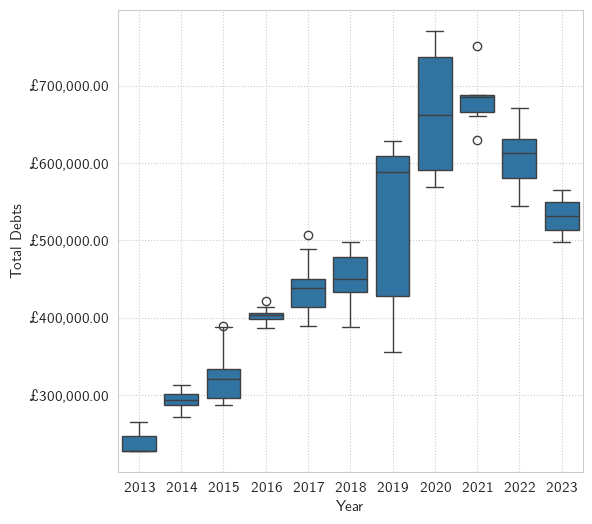

In [32]:
# reproduce "Figure 1: Figure 1: Average debts over years"
boxplot_annual_averge(data)
save2Vis('fig1')

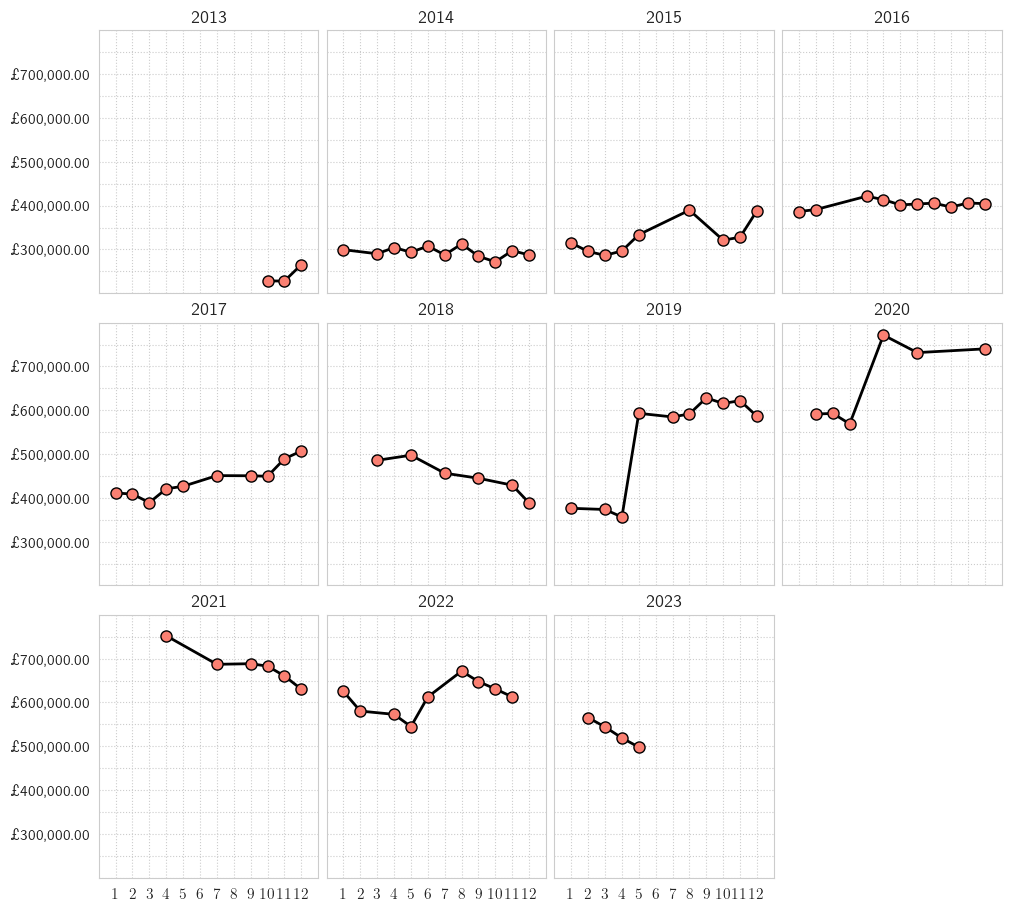

In [33]:
# reproduce "Figure 2: The total debts from all lenders over months and years"
plot_monthly_debt_history(data)
save2Vis('fig2')

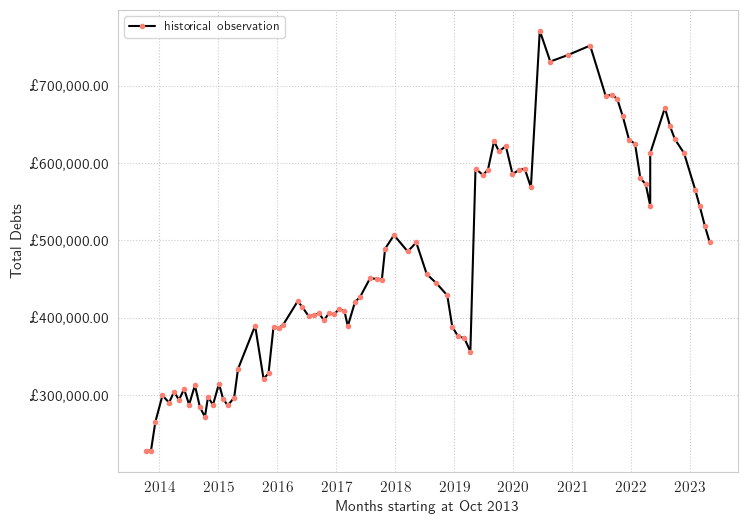

In [34]:
# reproduce "Figure 3: Total monthly debts from all lenders starting from October 2013"
plot_total_debt_history(data)
save2Vis('fig3')

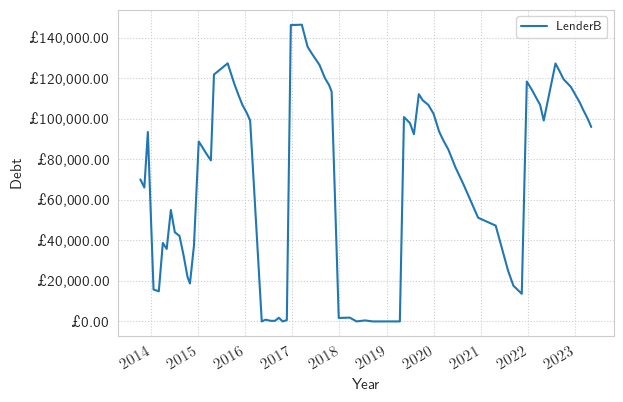

In [35]:
plot_which_lender_history(data, 'LenderB')
save2Vis('fig4')

***
<a id="predictive_modelling"></a>
# 5. Predictive modelling

> Given the borrowing history data, I would create uncertainty-aware Machine Learning models for forecasting future trends and imputing the missing values in the history. One key component of this analysis is **uncertainty modelling**. 

Specifically, both \textit{aleatoric} uncertainty and \textit{epistemic} uncertainty will be accounted for in this analysis. Typically, in a regression setting, we are interested in inferring a function/hyposis, parameterised by $\omega$, that are likely to have generated the observed data $\mathcal{D}: (\mathbf{x}_{i}, y_{i})_{i=1}^{N}$ of $N$ observations. 

\begin{equation}
    y_{i} = f_{\boldsymbol{\omega}}(\mathbf{x}_{i}) + \epsilon_{i}
    \label{eq:regression}
\end{equation}

where $\mathbf{x} \in \mathbb{R}^{K}$ and $\epsilon$ suggests the noise term. A typical assumption of Gaussian noise enables the model fitting via an approach of maximum likelihood estimation. This gives rise to a probabilistic interpretation of the data generating process. The likelihood, under the model, of seeing the data with known $\sigma^2$ is written as:

\begin{equation}
    p(y_{i}|\boldsymbol{\omega},\mathbf{x}_{i},\sigma^2)=\mathcal{N}(f_{\boldsymbol{\omega}}(\mathbf{x}_{i}),\sigma^2) \label{eq:gaussian_likehood}
\end{equation}

Optimising with the likelihood as the loss function, shown below, gives the inferred model, which formulates the conditional distribution $p(y^{*}|\mathbf{x}^{*}, \boldsymbol{\omega})$ given an unseen $\mathbf{x}^{*}$.

\begin{align}
    \boldsymbol{\omega}^{{MLE}} &= \arg \max_{\boldsymbol{\omega}} p(\mathcal{D}|\boldsymbol{\omega}) \nonumber \\
    &= \arg \max_{\boldsymbol{\omega}} \log p(\mathcal{D}|\boldsymbol{\omega}) \nonumber \\
    &= \arg \max_{\boldsymbol{\omega}} \log \Bigl[ \prod_{i} p(y_{i}|\mathbf{x}_{i}, \boldsymbol{\omega}) \Bigr] \nonumber \\
    &= \arg \max_{\boldsymbol{\omega}} \sum_{i} \log p(y_{i}|\mathbf{x}_{i}, \boldsymbol{\omega})
\end{align}


However, implicit in the above MLE procedure is the ignorance of model uncertainties (\textit{epistemic uncertainty}). 
The absence of enough data has restricted Machine Learning models from effectively learning the true relationship between features and labels (i.e. the underlying data generating process). Significant uncertainties exist on the model configurations that may have explained such limited data.
Consequently, such uncertainties further compromise the generalization power of learned models in that predictions from uncertain/unrepresentative models can still be unreliable and over confident, especially when doing extrapolation on unseen situations.


> **train/test split**

For a supervised task, people are mostly concerned with the model's generalisation power (i.e. predictive performance on unseen data). Such ability is typically evaluated, approximately, using testing data based on a train/validation/testing split. Cross validation is a common way to approximate such expected loss. However, it is in debate if it is appropriate for time series analysis to adopt cross validation as it jeopardize the temporal structure. It is more reasonable to adopt backtesting, which is time consuming per se.

In [36]:
x_train, y_train, x_test, y_test, tt = prepare_TrainTest_data(data, split=0.95)

In [37]:
current_month, start_month, last_month = get_date_month_index(data)

In [38]:
X_plot = np.linspace(start=start_month, stop=current_month, num=200).reshape(-1, 1)

> With the importance of uncertainty quantification in mind, given a very small data set subject to missing data. It's been found that in the that 33 months of records are missing from 2013 Oct - 2023 May and currently the number of data points is $N$=84. I will use Gaussian process for three reasons: (i) it accounts for the model uncertainty; (ii) it is efficient to compute on a small data set with analytic solution; (iii) it naturally deals with missing data;

Consider a generic regression setting as shown in Eq.~(\ref{eq:regression}). In order to account for model uncertainty, we infer a distribution over functions $p(f|\mathcal{D})$ given the data $\mathcal{D}: (\mathbf{X}, \mathbf{y})$ in a compact notation.
Note that I dropped the parametric representation of the function $f$ for a generalised notation. We are then interested in estimating the posterior distribution after seeing the data.

Gaussian Process (GP) represents a distribution of functions by, practically, an infinite dimensional multivariate Gaussian distribution. It defines a data generating process as:

\begin{align}
    f &\sim \mathcal{GP}(m(\mathbf{x}), \mathcal{K}(\mathbf{x}, \mathbf{x}')) \\
    y_{i} &\sim \mathcal{N}(f(\mathbf{x}_{i}), \sigma_{y}^2)
\end{align}
    
where $\mathcal{K}(\mathbf{x}, \mathbf{x}')$ denotes the covariance function (also known as kernel) and implicitly we assume Gaussian likelihood $\epsilon \sim \mathcal{N}(0, \sigma_{y}^2)$. As noted, the sampled function from GP is impossible to compute as it requires evaluation at an infinite number of points. Instead, one considers finite samples from a multivariate Gaussian. The joint distribution of the observed data and the latent noise-free function values on the test points can be written as:

$$
    \left( \begin{array}{c} \mathbf{y} \\ \mathbf{f}_{*} \end{array} \right) \sim \mathcal{N} \Bigg (\boldsymbol{0}, 
    \left( \begin{array}{cc} \mathbf{K}_{y} & \mathbf{K}_{*} \\
    \mathbf{K}_{*}^{T} & \mathbf{K}_{**} \end{array} \right) \Bigg)
$$

One of the perks with GP is that, within the Gaussian world, the posterior predictive density, given unseen test points $\mathbf{x}_{*}$, can be analytically written as:

$$
    f | \mathbf{x}_{*}, \mathbf{X}, \mathbf{y} \sim \mathcal{N}(\boldsymbol{\mu}_{*}, \boldsymbol{\Sigma}_{*})
$$

where 

\begin{align}
    \boldsymbol{\mu}_{*} &= \mathbf{K}_{*}^{T} \mathbf{K}_{y}^{-1} \mathbf{y} \\
    \boldsymbol{\Sigma}_{*} &= \mathbf{K}_{**} - \mathbf{K}_{*}^{T} \mathbf{K}_{y}^{-1} \mathbf{K}_{*}
\end{align}

The next challenge is then to infer the hyperparameters $\boldsymbol{\theta}$ of the designated kernel, which will be done by maximizing the marginal likelihood $y(\mathbf{y}|\mathbf{X}, \boldsymbol{\theta})$. Similarly, within a Gaussian world, such marginal likelihood can also be written analytically: 

$$
    \arg \max_{\boldsymbol{\theta}} \ \log p(\mathbf{y}|\mathbf{X}, \boldsymbol{\theta})
$$

In [39]:
model = gp_modelling(x_train, y_train)

2023-11-16 16:21:23.713032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 16:21:26.050764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10771 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:04:00.0, compute capability: 3.7
2023-11-16 16:21:26.052135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10787 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7
2023-11-16 16:21:26.053434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10787 MB m

> show the hyperparameters

In [40]:
gf.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.01747
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.64407
GPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.00072
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.71626
GPR.kernel.kernels[1].period,Parameter,Softplus,,True,(),float64,1.07198
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00095


In [41]:
y_mean, y_var = model.predict_y(X_plot)

> plotting the prediction on `test data` and on `future forecasting data`

> Figure below shows the Gaussian process modelling on the total debt. The left of the vertical green dash line denotes the training data. Observation between the green line and purple line suggests the test data, which is dated until 2023 May. Starting from the purple to the red line suggests the future forecasting, where we don't have ground truth, until the current date: Nov 2023. These forecasts had been done with access to only data as of 2023 May and can now be further validated at current moment to signal the generalisation power of the trained model. This actually reflects the concept of backtesting. Most importantly, we have given the predictive interval to prepare for uncertainty-informed decision making of the company, such as better managing the debts with risk in mind.

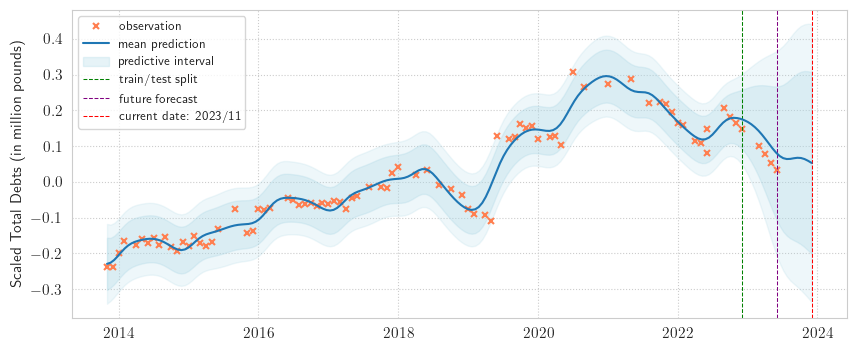

In [42]:
gp_plotting(X_plot, y_mean, y_var, tt)
save2Vis('fig5')

> Quantitatively, I have tabulated the performance quantitatively through a few metrics in Table below.
This allows the quantitative comparison between different modelling techniques. For example, a full-fledged time series model (such as Transformer) in future studies.

In [43]:
metrics_dict = evaluate_metrics(x_test, y_test, model)

In [44]:
print(pd.DataFrame(data = metrics_dict, index=[0]))

mae  interval_width  log_likelihood  PICP
0  0.041042         0.26078        1.637704   1.0

> **missing data imputation**

With the GP model, the values at the 33 missing months can be easily imputed, along with a predictive interval. The exact values of past missing months may not directly be interested. However, a complete past record enables more advanced models considering temporal effects, such as Transformer. These additional incorporation of temporal effects are key characteristics of state-of-the-art modelling techniques and can be significantly informative.

***
<a id="final_throughts"></a>
# 6. Final thoughts and discussion

### 6.1 Full-fledged modelling incorporating temporal effects and covariates

> Typically, the state-of-the-art time series modelling techniques will involve temporal effects and covariates. Consider the quantity-of-interest ($y$) as the target to be forecasted, an autoregressive scheme is commonly used to formulate the effects of past values on the future value. 

$$
    y_{t} = f(\mathbf{x}_{t}; \boldsymbol{\omega}) + \epsilon, \text{with}  \ \mathbf{x}_{t} = [y_{t-1}, \dots, y_{t-p}]
    \label{eq:AR}
$$

> This reflects an univariate situation. More commonly, there exist covariates (static or dynamic) that provide extra features to the forecast, i.e. $y_{t} = f(\mathbf{x}_{t}, \mathbf{z}; \boldsymbol{\omega})$ where $\mathbf{z}$ denotes covariates. Dynamic covariates may include other related variables, or temporal effects such as seasonal periodicity (yearly, monthly, etc). Static covariates may include calendar events, holidays that may affect the the $y_{t}$ considerably within a short time period. For example, Black Friday may affect the forecast of sales.

> In this analysis, a simplified analysis is conducted to forecast total debt as a function of time only. Given more data, I can deliver a more advanced analysis using the state-of-the-art Transformer model.

### 6.2 Knowledge-informed missing data imputation

> As noted above, depending on the task, to find out the exact value of the past missing data may not be directly interested to modellers. However, the goal of many imputation methods is to deliver a more accurate model based on a complete data set. Gaussian process can probabilistically impute the missing value as suggested in this analysis. But such reconstructed values do not deliver more information in the forecasting model as it is indeed the same model.

> Therefore, some other methods that can incorporate other knowledge into the modelling process may better inform the learning process and, subsequently, the forecasting. See [this paper](https://www.researchgate.net/publication/372476099_A_Bayesian_Augmented-Learning_framework_for_spectral_uncertainty_quantification_of_incomplete_records_of_stochastic_processes) for further details.
